# Dreamdata Conversion Prediction

## Task:

The task of this code challenge is to predict if a conversion (e.g. form
submission) would happen in or right after each session in the whole customer
journey.

So basically for each session in the user sessions data set, we need to predict if a conversion
will happen either during or right after that session. To do this we will have to train a model with the user sessions data and make sure it includes data where a conversion has already happened so that the model knows the probability of a conversion happening based on certain data input, e.g. session duration, device, source or event type to name a few.

## Model:

Firstly we have to determine which type of model to use. Since this is the first time I'm doing this I am starting my research using the BigQuery ML documentation: https://cloud.google.com/bigquery/docs/bqml-introduction

For the purpose of this task I am going to focus on internally trained models since they are built in BigQuery ML and do not need go externally to Vertex AI. Out of the available models in there it looks like we'll need to use one of the Regression models. Regression analysis allows you to determine which variables have an impact on the dependent variable (conversion: yes/no) you are trying to predict (https://hbr.org/2015/11/a-refresher-on-regression-analysis). Based on this the model can then actually predict the outcome. 

With this task we are trying to predict each session as either "conversion" or "no conversion", so we are basically categorising each session. Since we are not trying to predict a value but a category I am going to use a logistic regression model. BQML documentation states the following about this model which seems perfect for this:

"Logistic regression for classification; for example, determining whether a customer will make a purchase."

### Firstly pip install the GCP BigQuery API Client libraries

In [1]:
pip install google-cloud-bigquery

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install db-dtypes

  Using cached db_dtypes-1.1.1-py2.py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


### Connect to BigQuery account

In [5]:
#import the right libraries from GCP
from google.cloud import bigquery
from google.oauth2 import service_account

#this loads the API client credentials of the GCP service account that has access to the BQ table
credentials = service_account.Credentials.from_service_account_file(
'dreamdata-assessment-f8321f1e256c.json') 

#set the project ID the data is stored in + create the BQ Client
project_id = 'dreamdata-assessment'
client = bigquery.Client(credentials= credentials,project=project_id)

#run a simple query to test connection
query_job = client.query("""
   SELECT *
   FROM training_data.user_sessions
   LIMIT 1000 """)

df = query_job.to_dataframe()

print("Query results:")
print(df)

Query results:
     conversion                  conversion_time  user_id  sessionId  \
0         False                              NaT   221049          1   
1         False                              NaT   200632          2   
2         False                              NaT     4160          1   
3         False                              NaT   335639          1   
4         False                              NaT   353937          1   
..          ...                              ...      ...        ...   
995       False                              NaT   179171          3   
996        True 2020-05-27 05:21:37.877000+00:00  1035385          5   
997        True 2020-05-28 21:41:38.418000+00:00  1052891          1   
998       False                              NaT  1181811          1   
999       False                              NaT   570662          3   

     minutes_since_last_session      event     browser    os  device  \
0                             0  page_view      

### Data Exploration

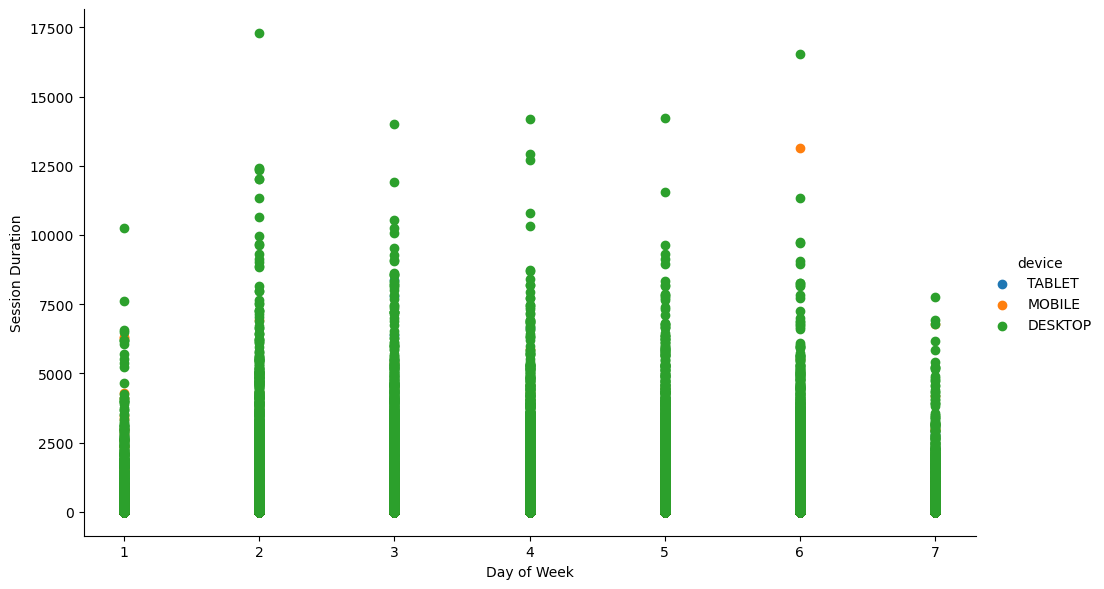

In [9]:
import seaborn
from  matplotlib import pyplot as plt

query = """
        SELECT 
        EXTRACT(DAYOFWEEK from session_start_time) start_day,
        *
        FROM `dreamdata-assessment.training_data.user_sessions` 
        WHERE conversion = TRUE
        """

data = client.query(query).to_dataframe()

fg = seaborn.FacetGrid(data=data, hue='device', height=6,aspect=1.67)
fg = fg.map(plt.scatter, 'start_day', 'session_duration_seconds').add_legend()
fg = fg.set_axis_labels(x_var="Day of Week", y_var="Session Duration")

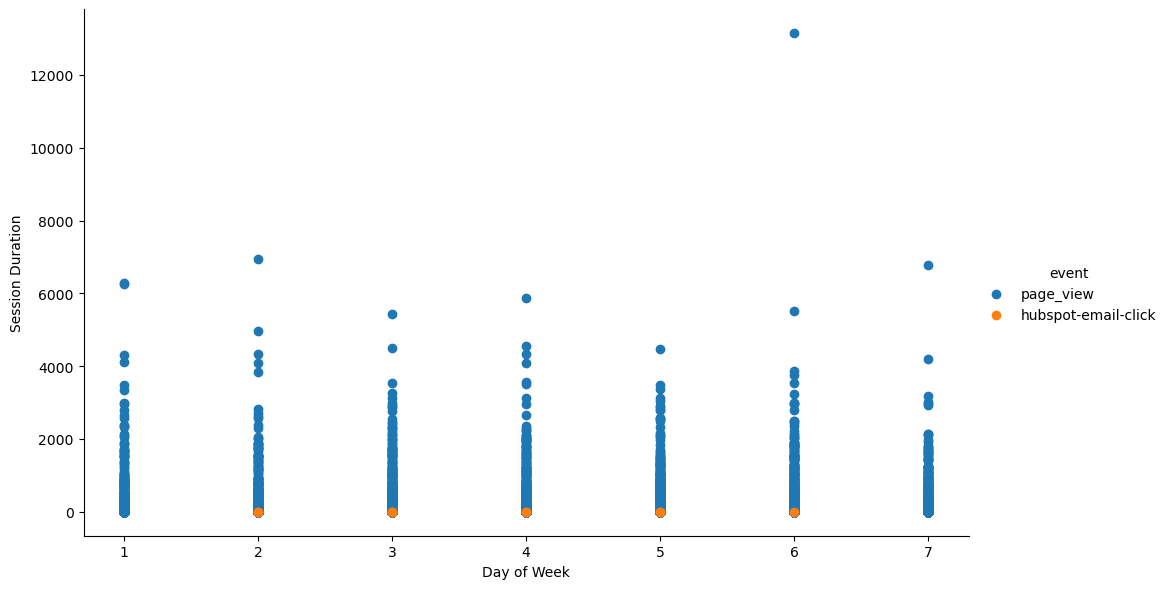

In [8]:
import seaborn
from  matplotlib import pyplot as plt

query = """
        SELECT 
        EXTRACT(DAYOFWEEK from session_start_time) start_day,
        *
        FROM `dreamdata-assessment.training_data.user_sessions` 
        WHERE conversion = TRUE
        and device = 'MOBILE'
        """

data = client.query(query).to_dataframe()

fg = seaborn.FacetGrid(data=data, hue='event', height=6,aspect=1.67)
fg = fg.map(plt.scatter, 'start_day', 'session_duration_seconds').add_legend()
fg = fg.set_axis_labels(x_var="Day of Week", y_var="Session Duration")

### Create the model

Firstly I created a VIEW in BQ that contains the data but with an extra label determining if the row is being used for 'training', 'evaluation' or 'prediction'

In [10]:
view_query = """
    CREATE OR REPLACE VIEW 
      training_data.model_input
      AS
    SELECT
      user_id,
      sessionId,
      session_duration_seconds,
      event,
      device,
      channel,
      event_count,
      country,
      SOURCE,
      conversion,
      CASE  
          WHEN MOD(user_id, 10) < 8 THEN 'training'
          WHEN MOD(user_id, 10) = 8 THEN 'evaluate'
          WHEN MOD(user_id, 10) = 9 THEN 'predict'
      END as dataframe
    FROM
      `dreamdata-assessment.training_data.user_sessions`
"""

query_job = client.query(view_query)

check_view_query = "select * from  training_data.model_input LIMIT 100"
df = client.query(check_view_query).to_dataframe()
df

,user_id,sessionId,session_duration_seconds,event,device,channel,event_count,country,SOURCE,conversion,dataframe
0,1280414,1,0,page_view,MOBILE,Organic Search,1,None,Bing,False,training
1,335074,1,0,page_view,MOBILE,Paid,1,None,SoMe,False,training
2,606140,1,0,page_view,MOBILE,Email,1,None,Email,False,training
3,673415,1,0,page_view,None,Paid,1,None,Google,False,training
4,66092,1,0,page_view,MOBILE,Organic Search,1,None,Google,False,training
...,...,...,...,...,...,...,...,...,...,...,...
95,606016,9427,0,page_view,MOBILE,Paid,1,None,RTB,False,training
96,200048,8714,0,page_view,MOBILE,Paid,1,None,RTB,False,evaluate
97,300597,1,0,page_view,MOBILE,Paid,1,None,RTB,False,training
98,739134,1,0,page_view,MOBILE,Paid,1,None,RTB,False,training


Then I use this view filtered on 'training' to create and train the model.

In [11]:
dataset_name = 'training_data'
model_name = 'conversion_prediction'

query = """
        SELECT 
           *
        FROM training_data.model_input
        WHERE dataframe = 'training'
"""

model_query = """
  CREATE OR REPLACE MODEL {0}.{1} 
    OPTIONS (
      model_type='LOGISTIC_REG',
      input_label_cols=['conversion']
    ) as {2}
""".format(dataset_name, model_name, query)

query_job = client.query(model_query)

### Now that the model has been created, we'll evaluate it

In [6]:
evaluate_query = "select * from ml.EVALUATE(MODEL training_data.conversion_prediction_test)"
df = client.query(evaluate_query).to_dataframe()
df

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1.0,1.0,1.0,1.0,1.059929e-07,1.0


Initially I used the full dataset as the training data, but when you see the evaluation of this model above, these numbers look too good to be true to me. This made me change my approach and create the above query just using certain variables. 

Ideally I'd have been able to figure out using the regression model which variables have an impact on the dependent variable conversion, but I couldn't figure out exactly how to do this. So in this case I just picked the ones that looked most impactful based on the data in those variables. Result of this model below.

In [15]:
evaluate_query = """select * from ml.EVALUATE(MODEL {0}.{1},
                    (
                        SELECT 
                           *
                        FROM training_data.model_input
                        WHERE dataframe = 'evaluate' 
                        
                    ))""".format(dataset_name, model_name)
df = client.query(evaluate_query).to_dataframe()
df

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.355888,0.107484,0.983567,0.165104,0.064182,0.930549


### Check the Feature Info of the model

In [16]:
featureinfo_query = "select * from ml.FEATURE_INFO(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(featureinfo_query).to_dataframe()
df

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,user_id,1.0,1349321.0,668473.084658,663622.0,385901.927985,<NA>,0,<NA>
1,sessionId,1.0,10540.0,78.752603,1.0,626.803711,<NA>,0,<NA>
2,session_duration_seconds,0.0,408799.0,211.557531,0.0,3264.820146,<NA>,0,<NA>
3,event,NaN,NaN,NaN,NaN,NaN,2,0,<NA>
4,device,NaN,NaN,NaN,NaN,NaN,4,138,<NA>
5,channel,NaN,NaN,NaN,NaN,NaN,8,0,<NA>
6,event_count,1.0,671.0,2.163137,1.0,3.930845,<NA>,0,<NA>
7,country,NaN,NaN,NaN,NaN,NaN,134,1744576,<NA>
8,SOURCE,NaN,NaN,NaN,NaN,NaN,50,0,<NA>
9,dataframe,NaN,NaN,NaN,NaN,NaN,1,0,<NA>


### Predict conversion outcome using the model

In [17]:
predict_query = """select * from ml.PREDICT(MODEL {0}.{1},
                    (
                        SELECT 
                           *
                        FROM training_data.model_input
                        WHERE dataframe = 'predict' 
                        
                    ))""".format(dataset_name, model_name)
df = client.query(predict_query).to_dataframe()
df

,predicted_conversion,predicted_conversion_probs,user_id,sessionId,session_duration_seconds,event,device,channel,event_count,country,SOURCE,conversion,dataframe
0,False,"[{'label': True, 'prob': 0.008376715386719278}...",1204499,1,0,page_view,MOBILE,Paid,1,None,Kragen,False,predict
1,False,"[{'label': True, 'prob': 0.007214854775759112}...",607959,1,0,page_view,MOBILE,Paid,1,None,Facebook,False,predict
2,False,"[{'label': True, 'prob': 0.009185336334884798}...",912659,5,0,page_view,MOBILE,referrer,1,None,DIS,False,predict
3,False,"[{'label': True, 'prob': 0.009687686023339701}...",839289,5,25,page_view,MOBILE,referrer,2,None,DIS,False,predict
4,False,"[{'label': True, 'prob': 0.00895072748194751},...",839489,3,0,page_view,TABLET,direct,1,None,DIS,False,predict
...,...,...,...,...,...,...,...,...,...,...,...,...,...
237039,False,"[{'label': True, 'prob': 0.014095674829509457}...",201179,358,0,page_view,MOBILE,direct,1,None,direct,False,predict
237040,False,"[{'label': True, 'prob': 0.014230027931416698}...",201179,197,0,page_view,MOBILE,direct,1,None,direct,False,predict
237041,False,"[{'label': True, 'prob': 0.007242710044869804}...",1146299,1,0,page_view,MOBILE,Paid,1,None,Facebook,False,predict
237042,False,"[{'label': True, 'prob': 0.007186984962722683}...",67269,1,0,page_view,MOBILE,Paid,1,None,Facebook,False,predict
